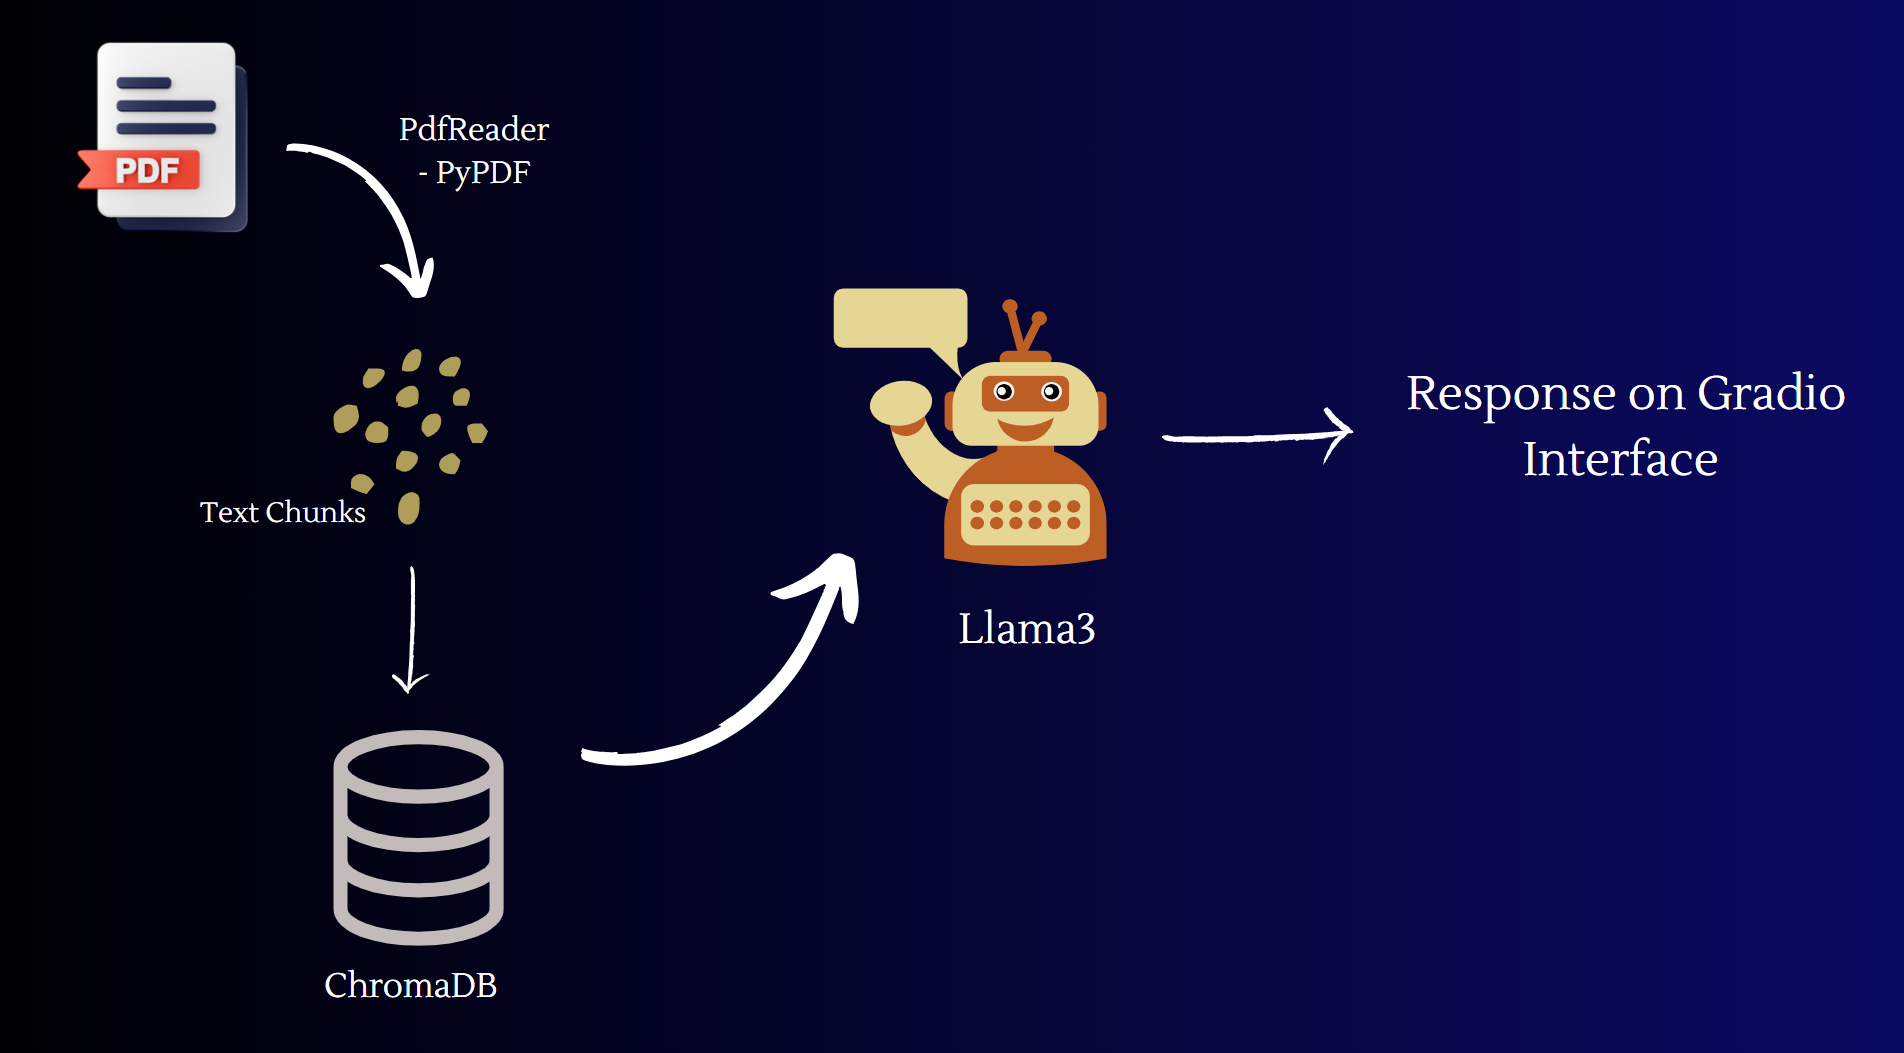

---
Introducing the ultimate exam preparation tool powered by cutting-edge technologies! This innovative tool seamlessly integrates **RAG (Retrieval Augmented Generation) model, Llama3, and ChromaDB**, delivering unparalleled efficiency and accuracy in academic query resolution. With a user-friendly interface provided by Gradio, you can now effortlessly upload PDFs and ask questions. Our tool processes the PDFs, extracts relevant text chunks, and stores them in ChromaDB, ensuring lightning-fast retrieval. Leveraging the power of the Llama3 model, it generates contextually rich responses to user queries, providing comprehensive insights and solutions. 

---

In [ ]:
!pip install -q gradio
!pip install -q chromadb
!pip install -q PyPDF2
!pip install -q python-dotenv
# !pip install replicate
!pip install -q groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 870.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/

In [ ]:
import gradio as gr
import chromadb
import PyPDF2
from dotenv import load_dotenv
import os
# import replicate
from groq import Groq
from google.colab import userdata

*Llama3*: It is a GROQ model used for chat completion. GROQ (Generative Retrieval of Question) models combine retrieval-based and generative-based approaches for natural language processing tasks like question answering and dialogue generation. <br>
*ChromaDB*: It is a document database used for storing and retrieving text documents. In this code, ChromaDB is used to store chunks of text extracted from PDF documents. These text chunks are later used for context retrieval during chat completion using the GROQ model.

In [ ]:
client = Groq(
    api_key=userdata.get('Groq'),
)
model_id="llama3-8b-8192"

In [ ]:
# Set up Chroma
chroma_client = chromadb.Client()

The query_replicate function first processes a PDF document using the process_pdf function and stores the chunks in a collection using ChromaDB. Then, it retrieves relevant context from ChromaDB and passes it along with the user query to a GROQ model (Llama3) for chat completion. The GROQ model leverages RAG techniques to generate a response based on the provided context and query.


---
**process_pdf Function:**
The process_pdf function takes a PDF file as input and extracts text from each page using PyPDF2.
It splits the extracted text into chunks using a special character as a splitter.
Unique IDs are generated for each chunk.
The chunks are then stored in a ChromaDB collection named "pdf_collection".
The function returns the created collection.<br><br>
**query_replicate Function:**
The query_replicate function takes a PDF file and a query as input.
It first deletes any existing collection named "pdf_collection" using ChromaDB.
Then, it processes the PDF file using the process_pdf function to store text chunks in a ChromaDB collection.
It queries ChromaDB to retrieve relevant context based on the user query.
The context along with the user query is passed to a GROQ model (Llama3) for chat completion.
The generated response from the Llama3 model is returned.

In [ ]:
def process_pdf(pdf_file):
    pdf_reader = PyPDF2.PdfReader(pdf_file)
    text = ""
    for page in range(len(pdf_reader.pages)):
        text += pdf_reader.pages[page].extract_text()

    text_splitter = chr(0x0)  # Add a special character to separate text chunks
    chunks = text.split(text_splitter)

    # Generate unique ids for each document
    ids = [f"doc_{i}" for i in range(len(chunks))]

    collection = chroma_client.create_collection(name="pdf_collection")
    collection.add(documents=chunks, ids=ids)

    return collection


# Function to query model and get response
def query_replicate(pdf_file, query):
    # Process PDF and store in Chroma
    try: # deletes the previous pdf_collection
      chroma_client.delete_collection(name="pdf_collection")
      chroma_client.list_collections()
    except:
      pass

    collection=process_pdf(pdf_file)
    print("Collections done")
    # Search Chroma for relevant chunks
    results = collection.query(    query_texts=[query],    n_results=1)
    context = "\n".join([doc[0] for doc in results["documents"]])
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": f"Based on the context: {context}\n\nHuman: {query}\nAssistant:"
            }
        ],
        model="llama3-8b-8192",
    )

    print(chat_completion.choices[0].message.content)
    return chat_completion.choices[0].message.content

In [ ]:
# UI with Gradio
with gr.Blocks(css=".gradio-container {background-color: #220042}") as demo:
    gr.Markdown("Exam Preparation Tool")
    with gr.Row():
        with gr.Column():
            pdf_file = gr.File(label="Upload PDF", file_count="single")
            query = gr.Textbox(label="Ask a question")
            submit_btn = gr.Button("Submit")
        with gr.Column():
            response = gr.Textbox(label="Response")

    submit_btn.click(query_replicate, inputs=[pdf_file, query], outputs=response)

demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a4ec9a228c75bcf280.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
